# ■ Computing Resource
## RunPod
## 1 x A40## 9 vCPU 50GB RAM

In [1]:
!pip install pypdf
!pip install -U langchain-community
!pip install sentence-transformers
!pip install -U bitsandbytes
!pip install PyPDF2
!pip install numpy==1.23.5
!pip install pandas
!pip install -U langchain-huggingface
!pip install accelerate>=0.26.0
!pip install fitz
!pip install frontend
!pip install pdfplumber
!pip install langchain PyPDFium2
!pip install faiss-gpu
!pip install grandalf
!pip install rank_bm25
!pip install tiktoken
!pip install -qU langchain-teddynote
!pip install matplotlib
!pip install chromadb
!pip install --upgrade langchain pydantic
!pip install pymupdf4llm
!pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached langchain_community-0.3.20-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain_core-0.3.48-py3-none-any.whl.metadata (5.9 kB)
  Using cached langchain-0.3.21-py3-none-any.whl.metadata (7.8 kB)
  Using cached aiohttp-3.11.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.8.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached langsmith-0.3.18-py3-none-any.whl.metadata (15 kB)
  Using cached langchain_text_splitters-0.3.7-py3-none-any.whl.metadata (1.9 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
Using cached langchain_community-0.3.20-py3-none-any.whl (2.5 MB)
Using cached aiohttp-3.11.14-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
Using cached dataclasses_json-0.6.

In [2]:
import os
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from langchain.document_loaders import PyPDFium2Loader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFacePipeline
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from transformers import pipeline
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM
from langchain.prompts import PromptTemplate
from sentence_transformers import SentenceTransformer
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import pymupdf4llm
from langchain.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import PDFMinerLoader
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.document_loaders import PDFMinerPDFasHTMLLoader
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain_teddynote.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever
import pdfplumber
import matplotlib.pyplot as plt

# Hyper Parameter

In [3]:
RAG_Embedding_model = "jhgan/ko-sbert-nli"
# BAAI/bge-m3

TEST_Embedding = "jhgan/ko-sbert-sts"
LLM_Model ="CarrotAI/Llama-3.2-Rabbit-Ko-3B-Instruct-2412"
# "beomi/OPEN-SOLAR-KO-10.7B"
# "yanolja/EEVE-Korean-Instruct-10.8B-v1.0"

model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True}

# Text splitter
N_Chunk_size = 1000
N_Chunk_overlab = 100

R_k = 3

# Ensemble Retirever
# 1. CSV
# 2. PDF
Ensemble_rate = [0.5, 0.5] 

# Sample Test
Max_token_length = 100

# EmbeddingsFilter
# threshold = 0.8

# 1. Load PDF
## Preprocess PDF

In [4]:
def clean_text(text):
    # 줄바꿈 제거
    #text = text.replace("\n", " ")  
    # 'KOSHA GUIDE' 제거
    text = text.replace("KOSHA GUIDE", "")  
    # 4자리 숫자(년도) 제거
    text = re.sub(r"\b\d{4}\b", "", text)
    # [참고'숫자'] 형태 제거
    text = re.sub(r"\[참고'\d+'\]", "", text)
    # '[글자]' 형태 제거
    text = re.sub(r"'\w+'", "", text)
    # '- 숫자 -' 형태 제거
    text = re.sub(r"-\s*\d+\s*-", "", text)
    # '<사진 숫자>' 형태 제거
    text = re.sub(r"<(사진|그림|표)\s*\d+>|(사진|그림|표)\s*\d+", "", text)
    # 불필요한 공백 정리
    text = re.sub(r"\s+", " ", text).strip()  
    return text

def load_pdfs_from_folder(folder_path):
    documents = []
    pdf_files = [f for f in os.listdir(folder_path) if f.endswith(".pdf")]
    
    # PDF 파일 로드 진행 상황 표시
    for file_name in tqdm(pdf_files, desc="PDF 파일 로드 중", unit="파일"):
        file_path = os.path.join(folder_path, file_name)
        with pdfplumber.open(file_path) as pdf:
            # 각 페이지 로드 진행 상황 표시
            for i in tqdm(range(len(pdf.pages)), desc=f"{file_name} 페이지 로드 중", unit="페이지"):
                page = pdf.pages[i]
                # 표와 이미지를 제외하고 텍스트만 추출
                text = page.extract_text()
                if text:
                    # 전처리 적용
                    cleaned_text = clean_text(text)
                    if cleaned_text:  # 전처리 후에도 텍스트가 남아있다면 추가
                        documents.append({
                            "page_content": cleaned_text,
                            "metadata": {
                                "source": file_path,
                                "page": i + 1
                            }
                        })
    return documents

# PDF 문서 로드
pdf_docs = load_pdfs_from_folder("건설안전지침/")


PDF 파일 로드 중:  24%|██▍       | 25/104 [00:37<01:22,  1.05s/파일]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:   0%|          | 0/20 [00:00<?, ?페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:  20%|██        | 4/20 [00:00<00:00, 29.42페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:  35%|███▌      | 7/20 [00:00<00:00, 24.44페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:  50%|█████     | 10/20 [00:00<00:00, 23.55페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:  65%|██████▌   | 13/20 [00:00<00:00, 24.77페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중:  80%|████████  | 16/20 [00:00<00:00, 25.31페이지/s]
흙막이공사(띠장긴장공법, Prestressed Wale Method) 안전보건 작업지침.pdf 페이지 로드 중: 100%|██████████| 20/20 [00:00<00:00, 20.39페이지/s]
PDF 파일 로드 중:  33%|███▎      | 34/104 [00:45<01:12,  1.03s/파일]
해상 RCD 현장타설 말뚝공사(현수교, 사장교) 안전작업 지침.pdf 페이지 로드 중:   0%|          | 0/19 [00:00<?, ?페이지/s]
PDF 파일 로드 중:  

In [5]:
Page_num = 150
print(pdf_docs[Page_num])

{'page_content': 'C (5) 부재 인양 시 신호수 배치 계획을 수립하고 배치 및 신호체계 수립을 철저 히 하여야 한다. 6. 앵커리지 안전작업 (1) 콘크리트 타설 규모는 콘크리트 생산 및 타설 능력을 고려하여 구조물에 유해한 균열이 발생되지 않도록 계획되어야 한다. (2) 구체는 매스콘크리트 구조물이므로 시공성과 온도균열 제어를 고려해서 콘 크리트의 수직 및 수평 분할을 결정하여야 한다. (3) 수평타설 이음부에는 부착력을 높이기 위해 신콘크리트를 타설하기 전에 고압공기와 워터제트를 사용하여 반드시 레이턴스를 제거하여야 한다. (4) 사용되는 콘크리트의 배합은 원하는 강도한도내에서 가능한 단열온도 상승 계수(K)가 낮은 것을 사용해야 하며, 배합이 결정되면 이에 대한 온도해석 을 통해 수화열 균열을 방지하기 위해 Pipe cooling 등을 고려하여야 한다. (5) 앵커리지에 시공되는 쉬스가 설계도에 따라 정 위치에 정확하게 배치되어 있는지를 확인하여야 한다. (6) 주케이블을 최종적으로 앵커리지에 정착시켜 주는 정착구가 PS강선축에 직 각으로 고정되어 있는지를 확인하여야 한다. (7) 콘크리트 타설시 쉬스내에 콘크리트가 흘러 들어가지 않도록 쉬스단부 및 정착구 부분을 세심하게 주의를 기울여 타설하여야 한다. (8) 긴장된 강연선은 부식방지를 위해 가능한 빨리 그라우팅을 실시하여야 한다. 7. 주탑 안전작업 7.1 강재 주탑', 'metadata': {'source': '건설안전지침/현수교 교량공사 안전보건작업 지침.pdf', 'page': 9}}


# 2. Text Splitter

In [6]:
def split_documents(documents, chunk_size=1000, chunk_overlap=100):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False,
    )

    chunks = []
    page_lengths = []

    for doc in documents:
        splits = text_splitter.split_text(doc["page_content"])

        page_length = len(doc["page_content"])
        page_lengths.append({
            "source": doc["metadata"]["source"],
            "page": doc["metadata"]["page"],
            "page_length": page_length
        })

        for split in splits:
            chunks.append({
                "source": doc["metadata"]["source"],
                "page_number": doc["metadata"]["page"],
                "text": split
            })

    return chunks, page_lengths

# PDF 문서에서 텍스트 분할 및 페이지 길이 확인
pdf_chunks, page_lengths = split_documents(pdf_docs)

In [75]:
pdf_chunks[45]

{'source': '건설안전지침/지붕공사 안전보건작업 기술지침.pdf',
 'page_number': 6,
 'text': 'C (2) 그 밖의 용어의 정의는 이 지침에서 특별한 규정이 있는 경우를 제외하고는 산업 안전보건법, 같은 법 시행령, 같은 법 시행규칙, 안전보건규칙 및 관련 고시에서 정하는 바에 따른다. 4. 지붕 위 작업안전 일반기준 4.1 안전에 관한 일반사항 모든 지붕작업에서는 안전한 작업공간이 마련되어야 한다. 지붕작업 시 다음과 같은 안전작업을 위한 방법, 필요 장비, 작업자에 대한 세부사항 등이 마련되어야 한다. (1) 추락 방지책, 필요장비 (2) 지붕 아래에 있는 작업자와 일반인에 가해지는 위험을 통제하는 방법 (3) 현장 감독자 임명 및 위험요소를 효과적으로 통제할 수 있는 담당자 지명 (4) 안전작업을 위한 훈련 (5) 안전작업을 위한 작업방법 변경 (6) 건강상 위험요소 통제방법 4.2 안전작업에 필요한 시설 및 장비 지붕 위에서 작업 시 안전 시설이나 장비는 다음과 같다. (1) 발판, 사다리, 이동식 접근 장비 (2) 고정식 및 이동식 발판 타워'}

In [8]:
page_lengths_values = [p['page_length'] for p in page_lengths]

# 최대, 최소, 평균 길이 출력
max_length = max(page_lengths_values)
min_length = min(page_lengths_values)
avg_length = np.mean(page_lengths_values)

print(f"📏 최대 페이지 길이: {max_length}")
print(f"📏 최소 페이지 길이: {min_length}")
print(f"📏 평균 페이지 길이: {avg_length:.2f}")

📏 최대 페이지 길이: 2679
📏 최소 페이지 길이: 1
📏 평균 페이지 길이: 587.25


# Reduce Page

In [9]:
# page_lengths에서 인덱스와 page_length 추출
page_lengths_values_with_index = [(index, p['page_length']) for index, p in enumerate(page_lengths)]

# DataFrame 생성
df_page_lengths = pd.DataFrame(page_lengths_values_with_index, columns=["Index", "Page Length"])

# 결과 출력
df_page_lengths_filtered = df_page_lengths[df_page_lengths["Page Length"] <= 50]

# 결과 출력
df_page_lengths_filtered.head()

,Index,Page Length
0,0,40
19,19,34
40,40,43
62,62,47
64,64,33


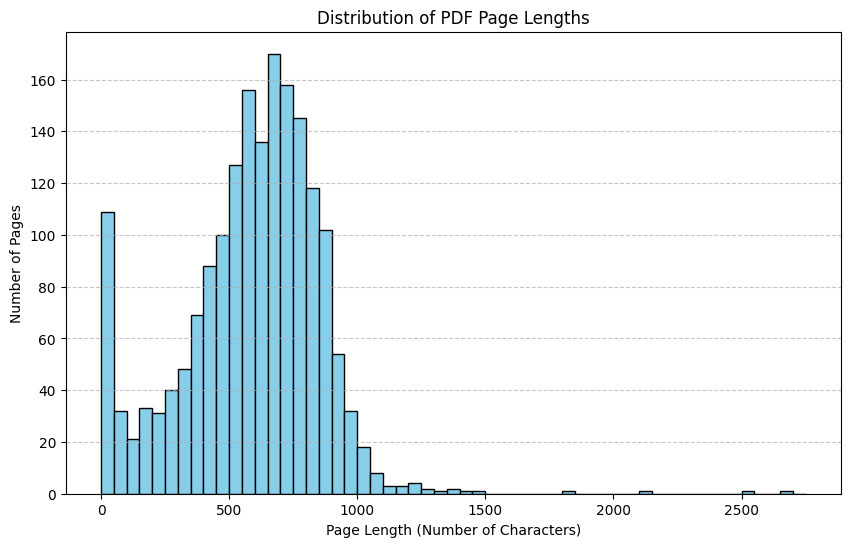

Bin 0 - 50: 109 pages
Bin 50 - 100: 32 pages
Bin 100 - 150: 21 pages
Bin 150 - 200: 33 pages
Bin 200 - 250: 31 pages
Bin 250 - 300: 40 pages
Bin 300 - 350: 48 pages
Bin 350 - 400: 69 pages
Bin 400 - 450: 88 pages
Bin 450 - 500: 100 pages
Bin 500 - 550: 127 pages
Bin 550 - 600: 156 pages
Bin 600 - 650: 136 pages
Bin 650 - 700: 170 pages
Bin 700 - 750: 158 pages
Bin 750 - 800: 145 pages
Bin 800 - 850: 118 pages
Bin 850 - 900: 102 pages
Bin 900 - 950: 54 pages
Bin 950 - 1000: 32 pages
Bin 1000 - 1050: 18 pages
Bin 1050 - 1100: 8 pages
Bin 1100 - 1150: 3 pages
Bin 1150 - 1200: 3 pages
Bin 1200 - 1250: 4 pages
Bin 1250 - 1300: 2 pages
Bin 1300 - 1350: 1 pages
Bin 1350 - 1400: 2 pages
Bin 1400 - 1450: 1 pages
Bin 1450 - 1500: 1 pages
Bin 1500 - 1550: 0 pages
Bin 1550 - 1600: 0 pages
Bin 1600 - 1650: 0 pages
Bin 1650 - 1700: 0 pages
Bin 1700 - 1750: 0 pages
Bin 1750 - 1800: 0 pages
Bin 1800 - 1850: 1 pages
Bin 1850 - 1900: 0 pages
Bin 1900 - 1950: 0 pages
Bin 1950 - 2000: 0 pages
Bin 2000 - 2

In [10]:
# Define the bins with intervals of 100
bin_intervals = range(0, max_length + 100, 50)

# Plot the histogram with the new bin intervals
plt.figure(figsize=(10, 6))
plt.hist(page_lengths_values, bins=bin_intervals, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Distribution of PDF Page Lengths")
plt.xlabel("Page Length (Number of Characters)")
plt.ylabel("Number of Pages")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print the counts for each bin
counts, bin_edges = np.histogram(page_lengths_values, bins=bin_intervals)

# Display the bin ranges and corresponding counts
for i in range(len(counts)):
    print(f"Bin {bin_edges[i]} - {bin_edges[i+1]}: {counts[i]} pages")

In [11]:
pdf_chunks[808]

{'source': '건설안전지침/교량공사(P.S.M공법) 안전작업 지침.pdf',
 'page_number': 9,
 'text': 'C 6. 세그먼트(Segment)의 제작․운반․가설 안전작업 세그먼트 제작․운반․가설개요 • 몰드 설치 세그먼트 제작 • 철근 가공장 및 야적장 설치 • 타워크레인 및 겐츄리크레인 설치 • 보일러 및 증기양생시설 설치 ⇩ • 세그먼트 야적장 설치 • 측량대, 폐수처리시설 설치 세그먼트 운반 • 세그먼트 운반 ⇩ • 세그먼트에 스프레더 빔 설치 세그먼트 인양 • 겐츄리크레인으로 인양 ⇩ • 에폭시 도포 세그먼트 가설 • 가설 강봉으로 접합 ⇩ • 쉬스관 설치 강연선 인장 • 정착구 설치 및 인장 6.1 세그먼트 제작․운반 (1) 교량상부 런칭거더 가설, 세그먼트의 제작․운반, 작업대 추진, 인장작업, 기 타작업이 포함된 작업계획서를 수립하여야 한다. (2) 작업계획은 직선구간, 곡선구간 등 작업형태(Type)별로 수립하여야 한다. (3) 제작장에 설치하는 겐츄리크레인 및 타워크레인은 설치 사용 전에 관계기관 으로부터 안전인증을 받아야 한다. (4) 제작장 내의 근로자 이동통로에는 가설통로를 설치하고 양측 단부에는 안 전난간을 설치하는 등 추락위험장소에는 추락방지조치를 하여야 한다.'}

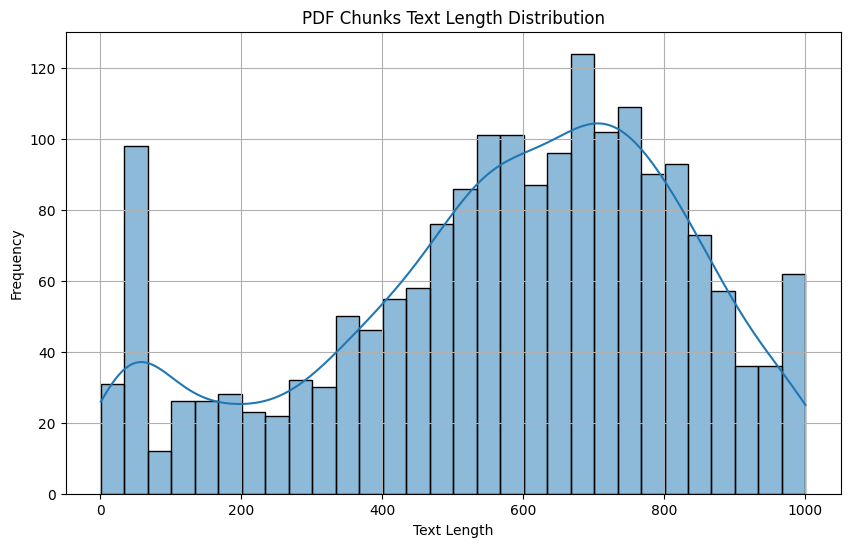

In [12]:
import seaborn as sns
# 'text'의 길이를 계산
text_lengths = [len(chunk['text']) for chunk in pdf_chunks]

# 분포도 그리기
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True)
plt.title('PDF Chunks Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
# 0에서 1000 사이의 길이를 가진 요소의 수 확인
filtered_lengths = [length for length in text_lengths if 0 <= length <= 1000]

# 구간 설정
bin_intervals = range(0, 1050, 50)

# 각 구간의 개수 계산
counts, bin_edges = np.histogram(filtered_lengths, bins=bin_intervals)

# 각 구간의 범위와 개수 출력
for i in range(len(counts)):
    print(f"Bin {bin_edges[i]} - {bin_edges[i+1]}: {counts[i]} pages")

Bin 0 - 50: 109 pages
Bin 50 - 100: 32 pages
Bin 100 - 150: 40 pages
Bin 150 - 200: 40 pages
Bin 200 - 250: 34 pages
Bin 250 - 300: 42 pages
Bin 300 - 350: 54 pages
Bin 350 - 400: 71 pages
Bin 400 - 450: 89 pages
Bin 450 - 500: 102 pages
Bin 500 - 550: 128 pages
Bin 550 - 600: 158 pages
Bin 600 - 650: 136 pages
Bin 650 - 700: 170 pages
Bin 700 - 750: 158 pages
Bin 750 - 800: 145 pages
Bin 800 - 850: 118 pages
Bin 850 - 900: 104 pages
Bin 900 - 950: 57 pages
Bin 950 - 1000: 79 pages


In [14]:
# Bin 0 - 100에 해당하는 인덱스 찾기
bin_0_to_100_indices = [i for i, length in enumerate(filtered_lengths) if 0 <= length < 100]

# Bin 0 - 100에 해당하는 요소 제거
filtered_lengths = [length for i, length in enumerate(filtered_lengths) if i not in bin_0_to_100_indices]

In [15]:
# 제거 후 결과 출력
print("제거 후 filtered_lengths의 길이:", len(filtered_lengths))

제거 후 filtered_lengths의 길이: 1725


# ★ RAG (Retrieval Augmented Generation)

# 2. CSV Load

In [16]:
# 5. 데이터 전처리 (Train & Test 데이터)
train = pd.read_csv('./train.csv', encoding='utf-8-sig')
test = pd.read_csv('./test.csv', encoding='utf-8-sig')

## 2-1 Column Drop

In [17]:
# 특정 컬럼 제거
columns_to_drop = ['발생일시', '사고인지 시간', '날씨', '기온', '습도', '연면적', '층 정보']

# train 데이터에서 컬럼 제거
train = train.drop(columns=columns_to_drop)

# test 데이터에서 컬럼 제거
test = test.drop(columns=columns_to_drop)

In [18]:
# 결측치 처리 (빈 문자열로 채우기)
train['공사종류'] = train['공사종류'].fillna('')
train['공종'] = train['공종'].fillna('')
train['사고객체'] = train['사고객체'].fillna('')
train['작업프로세스'] = train['작업프로세스'].fillna('')
train['사고원인'] = train['사고원인'].fillna('')

test['공사종류'] = test['공사종류'].fillna('')
test['공종'] = test['공종'].fillna('')
test['사고객체'] = test['사고객체'].fillna('')

In [19]:
# 데이터 전처리
train['공사종류(대분류)'] = train['공사종류'].str.split(' / ').str.get(0)
train['공사종류(중분류)'] = train['공사종류'].str.split(' / ').str.get(1)

train['공종(대분류)'] = train['공종'].str.split(' > ').str[0]
train['공종(중분류)'] = train['공종'].str.split(' > ').str[1]
train['사고객체(대분류)'] = train['사고객체'].str.split(' > ').str[0]
train['사고객체(중분류)'] = train['사고객체'].str.split(' > ').str[1]

test['공사종류(대분류)'] = test['공사종류'].str.split(' / ').str[0]
test['공사종류(중분류)'] = test['공사종류'].str.split(' / ').str[1]
test['공종(대분류)'] = test['공종'].str.split(' > ').str[0]
test['공종(중분류)'] = test['공종'].str.split(' > ').str[1]
test['사고객체(대분류)'] = test['사고객체'].str.split(' > ').str[0]
test['사고객체(중분류)'] = test['사고객체'].str.split(' > ').str[1]

In [20]:
# 훈련 데이터 통합 생성
combined_training_data = train.apply(
    lambda row: {
        "question": (
            f"'{row['작업프로세스']}', '{row['인적사고']}', '{row['사고원인']}' "
        ),
        "answer": row["재발방지대책 및 향후조치계획"]
    },
    axis=1
)

combined_training_data = pd.DataFrame(list(combined_training_data))

In [21]:
combined_training_data = pd.concat([train['ID'], combined_training_data], axis=1)
combined_training_data['Type'] = 'csv'
combined_training_data.head(5)

,ID,question,answer,Type
0,TRAIN_00000,"'설치작업', '떨어짐(5미터 이상 ~ 10미터 미만)', '고소작업 중 추락 위험...",고소작업 시 추락 위험이 있는 부위에 안전장비 설치.,csv
1,TRAIN_00001,"'운반작업', '끼임', '부주의'",재발 방지 대책 마련과 안전교육 실시.,csv
2,TRAIN_00002,"'형틀 및 목공', '넘어짐(미끄러짐)', '3층 슬라브 작업시 이동중 미끄러짐'",현장자재 정리와 안전관리 철저를 통한 재발 방지 대책 및 공문 발송을 통한 향후 조...,csv
3,TRAIN_00003,"'조립작업', '기타', '교각 기초철근 조립 중 강한 바람에 의해 기둥측 주철근이...","위험성 평가 및 교육을 통해 작업장 내 위험요인과 안전수칙을 근로자에게 전파하고, ...",csv
4,TRAIN_00004,"'해체작업', '넘어짐(미끄러짐)', '근로자의 부주의'",자재 정리 작업 시 세부 작업 방법에 대한 교육 실시와 작업 구간 이동 경로 점검 ...,csv


In [22]:
train_documents = [
    f"Q: {q1}\nA: {a1}" 
    for q1, a1, in zip(combined_training_data['question'], combined_training_data['answer'])
]

In [23]:
train_documents[:5]

["Q: '설치작업', '떨어짐(5미터 이상 ~ 10미터 미만)', '고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.' \nA: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.",
 "Q: '운반작업', '끼임', '부주의' \nA: 재발 방지 대책 마련과 안전교육 실시.",
 "Q: '형틀 및 목공', '넘어짐(미끄러짐)', '3층 슬라브 작업시 이동중  미끄러짐' \nA: 현장자재 정리와 안전관리 철저를 통한 재발 방지 대책 및 공문 발송을 통한 향후 조치 계획.",
 "Q: '조립작업', '기타', '교각 기초철근 조립 중 강한 바람에 의해 기둥측 주철근이 균형을 잃고 전도되어, 하부에서 작업 중이던 철근공 2명이 철근에 부딪힌 사고' \nA: 위험성 평가 및 교육을 통해 작업장 내 위험요인과 안전수칙을 근로자에게 전파하고, 근로자 안전교육을 강화하며, 본 사고와 관련된 유사 피해 발생 방지를 위한 안전교육을 실시할 계획.",
 "Q: '해체작업', '넘어짐(미끄러짐)', '근로자의 부주의' \nA: 자재 정리 작업 시 세부 작업 방법에 대한 교육 실시와 작업 구간 이동 경로 점검 후 장애물 사전 정리 작업 실시."]

최대 길이: 868
최소 길이: 34
평균 길이: 137.26


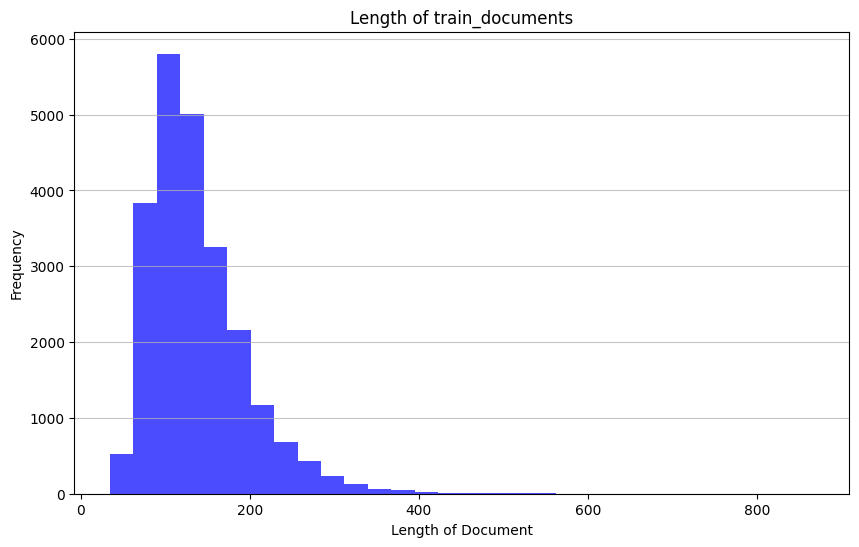

In [24]:
import matplotlib.pyplot as plt

# train_documents의 각 요소의 길이 계산
lengths = [len(doc) for doc in train_documents]

# 최대, 최소, 평균 계산
max_length = np.max(lengths)
min_length = np.min(lengths)
mean_length = np.mean(lengths)

# 결과 출력
print(f"최대 길이: {max_length}")
print(f"최소 길이: {min_length}")
print(f"평균 길이: {mean_length:.2f}")

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color='blue', alpha=0.7)
plt.title('Length of train_documents')
plt.xlabel('Length of Document')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


# 3. Text Embedding

In [25]:

# 6. 임베딩 모델 선택 (훈련 데이터)
embedding_model_name = RAG_Embedding_model
embedding = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/tmp/ipykernel_854/532052001.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 4. Vector DB
## PDF -> FAISS
## CSV -> Chroma

In [26]:
# 텍스트 추출
text_set = [chunk["text"] for chunk in pdf_chunks] 

# 메타데이터 추출 (Type 추가)
metadata_set = [
    {
        "source": chunk["source"], 
        "page_number": chunk["page_number"],
    } 
    for chunk in pdf_chunks
]

In [27]:
# 메타데이터 추출
metadata_set_CSV = [
    {
        "ID": row["ID"],
        "공사종류(대분류)": row["공사종류(대분류)"],
        "공사종류(중분류)": row["공사종류(중분류)"],
        "공종(대분류)": row["공종(대분류)"],
        "공종(중분류)": row["공종(중분류)"],
        "사고객체(대분류)": row["사고객체(대분류)"],
        "사고객체(중분류)": row["사고객체(중분류)"]
    }
    for _, row in train.iterrows()
]


In [28]:
# metadata_set_CSV를 DataFrame으로 변환
df_metadata = pd.DataFrame(metadata_set_CSV)

# NaN 값이 있는지 확인
nan_check = df_metadata.isna().any()

# 결과 출력
print("각 컬럼의 NaN 여부:\n", nan_check)

# NaN 값이 있는 행 추출
nan_rows = df_metadata[df_metadata.isna().any(axis=1)]

# NaN 값이 있는 행이 있다면 출력
if not nan_rows.empty:
    print("NaN 값을 포함한 행:\n", nan_rows)
else:
    print("NaN 값이 포함된 행이 없습니다.")


각 컬럼의 NaN 여부:
 ID           False
공사종류(대분류)    False
공사종류(중분류)     True
공종(대분류)      False
공종(중분류)       True
사고객체(대분류)    False
사고객체(중분류)     True
dtype: bool
NaN 값을 포함한 행:
                 ID 공사종류(대분류) 공사종류(중분류) 공종(대분류)    공종(중분류) 사고객체(대분류) 사고객체(중분류)
2856   TRAIN_02856        건축       건축물                NaN        기타        기타
2895   TRAIN_02895        건축       건축물      건축   철근콘크리트공사                 NaN
4081   TRAIN_04081        건축       건축물      건축       방수공사                 NaN
4420   TRAIN_04420        건축       건축물      건축   건축물 부대공사                 NaN
4562   TRAIN_04562    산업환경설비    산업생산시설      토목       항만공사                 NaN
...            ...       ...       ...     ...        ...       ...       ...
23363  TRAIN_23363        건축       건축물      건축       수장공사                 NaN
23380  TRAIN_23380        건축       건축물      건축  해체 및 철거공사                 NaN
23386  TRAIN_23386        건축       건축물      기타         기타                 NaN
23414  TRAIN_23414        건축       건축물      기

In [29]:
metadata_set[:10]

[{'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 1},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 2},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 3},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 4},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 5},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 6},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 7},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 8},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 9},
 {'source': '건설안전지침/강박스거더 교량공사 안전보건작업 지침.pdf', 'page_number': 10}]

In [30]:
# Train
vectorstore = Chroma.from_texts(train_documents, embedding, metadatas=metadata_set_CSV)  

# PDF
vectorstore2 = FAISS.from_texts(text_set, embedding, metadatas=metadata_set) 

# 5. Retriever (Ensemble Retriever)

In [31]:
# Train
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": R_k})

# PDF
retriever2 = vectorstore2.as_retriever(search_type="similarity", search_kwargs={"k": R_k})

In [32]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever, retriever2],
    weights=Ensemble_rate,
)

In [33]:
# LLM 모델 로드 (4-bit 양자화)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForCausalLM.from_pretrained(LLM_Model, quantization_config=bnb_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(LLM_Model)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

In [34]:
text_generation_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer,
    do_sample=False,  # 결정론적 생성
    return_full_text=False, 
    max_new_tokens=Max_token_length,
    device_map="auto"
)

# 경고를 비활성화할 수도 있습니다.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='transformers')


Device set to use cuda:0


# 6. Prompt Design

In [35]:
prompt_template = """
Your mission is to be a safety expert answer bot. When given the {question}, you must provide an answer **only** if the question is related to **construction, safety, or safety measures**. 

If the question is **NOT** related to **construction, construction safety tasks, or construction safety plan tasks**, respond with:

### 답변 : "업무와 관련이 없는 질문입니다."
### 끝.

Your answer **MUST** be in **only one sentence.
Your answer **MUST** be written **only in Korean**.

If any of the above instructions are violated, a penalty will be applied.

Make sure to strictly follow these rules.

### 질문:
{question}
"""

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# 커스텀 프롬프트 생성
prompt = PromptTemplate(
    input_variables=["question"],
    template=prompt_template,
)


/tmp/ipykernel_854/4203377173.py:20: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


# 7. Reference Check

In [36]:
import random

Sample_num = 5

# combined_training_data에서 랜덤하게 5개 샘플 선택
sample_questions = random.sample(list(combined_training_data['question']), Sample_num)

# 각 샘플에 대해 compression_retriever에서 검색된 문서 확인
for idx, question in enumerate(sample_questions):
    print(f"샘플 {idx+1}: {question}\n")

    # 검색 수행
    retrieved_docs = ensemble_retriever.get_relevant_documents(question)

    print("검색된 문서들:")
    for doc_idx, doc in enumerate(retrieved_docs):
        print(f"Document {doc_idx+1}: {doc.page_content}")
        print(f"Meta Data : {doc.metadata}\n")  # 메타데이터 출력
    
    print("=" * 100)  # 가독성을 위한 구분선


샘플 1: '절단작업', '기타', '합판절단시 이물질 미제거 및 보안경 미착용으로 인한 사고' 

검색된 문서들:
Document 1: Q: '기타', '절단, 베임', '작업중 재료정비중 사고발생' 
A: 안전사고 예방을 위한 보호대책 수립.
Meta Data : {'ID': 'TRAIN_07929', '공사종류(대분류)': '건축', '공사종류(중분류)': '건축물', '공종(대분류)': '기타', '공종(중분류)': '기타', '사고객체(대분류)': '건설자재', '사고객체(중분류)': '철망'}

Document 2: C 10. 조립식 안전난간 1) 도식 가) 슬래브용 및 철골용 나) 발코니용 다) 꽃이용 [] 조립식 안전난간 2) 점검기준 점검 종류 점검 점검부위 점검항목 폐기기준 비고 일상 정기 방법 변형 변형, 휘어짐, 뒤틀림이 현저하여 정비 ○ 육안 휘어짐, 뒤틀림 가 불가능한 것 용접부 균열, 육안 용접부 부식이 현저하여 정비가 불가능 1. 공통사항 ○ 부식 NDT 한 것[균열이 있는 것] 콘크리트 등의 콘크리트 등 부착물이 현저하여 정비가 ○ 육안 부착물 불가능한 것 구부러짐 ○ 구부러짐이 현저하여 교정이 불가능한 것 육안 기둥재 균열 ○ 균열이 있는 것 NDT 움푹 들어감 ○ 육안 움푹 들어감이 현저하여 정비가 불가능 한 것 2. 부재/ 나사부의 마모 ○ 육안 마모가 현저하여 정비가 불가능한 것 부품 고정부 핸들 및 ○ 육안 이상이 현저하여 정비가 불가능한 것 장착부의 이상 구부러짐 ○ 육안 구부러짐이 현저하여 정비가 불가능한 것 수평 육안 난간대 균열 ○ 균열이 있는 것 NDT 휨강도 : 파괴되는 것 안전난간기둥 ○ ○ 성능시험 수직처짐량 : 100mm를 초과하는 것 수평 난간대 휨강도 : 파괴되는 것 ○ ○ 성능시험 체결부 회전방지성능 : 회전되는 것 방호장치 미끄럼이 발생하는 것 3. 성능기준 의무안전 고정부 ○ ○ 성능시험 미 시끄 험러짐 탈하 락중 이을 나 제 헐거 거 후 움 체 등결 부 이의 상 인증고시 이 발생하는 것 휨강도 

/tmp/ipykernel_854/1023965736.py:13: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = ensemble_retriever.get_relevant_documents(question)


# 8. RAG Chain

In [37]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [38]:
chain = (
    {"context": ensemble_retriever|format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# chain = (
#     {"context": ensemble_retriever|format_docs, "question": RunnablePassthrough()}
#     | prompt
#     | llm
#     | StrOutputParser()
# )

# 9. Visualization in Langchain

In [39]:
chain.get_graph().print_ascii()

           +---------------------------------+          
           | Parallel<context,question>Input |          
           +---------------------------------+          
                   ***               ***                
                ***                     **              
              **                          ***           
+-------------------+                        **         
| EnsembleRetriever |                         *         
+-------------------+                         *         
          *                                   *         
          *                                   *         
          *                                   *         
   +-------------+                     +-------------+  
   | format_docs |                     | Passthrough |  
   +-------------+*                    +-------------+  
                   ***               ***                
                      ***         ***                   
                         **    

# 10. Sample Test

In [40]:
# 테스트 데이터 통합 생성
combined_test_data = test.apply(
    lambda row: {
        "question": (
            f"긴급상황입니다. 작업 프로세스는 '{row['작업프로세스']}'이며, 인적사고는 '{row['인적사고']}' 그리고 사고 원인은 '{row['사고원인']}'입니다. "
            f"재발 방지 대책 및 향후 조치 계획은 무엇인가요?"
        )
    },
    axis=1
)

# DataFrame으로 변환
combined_test_data = pd.DataFrame(list(combined_test_data))


In [41]:
# 테스트 실행 후 결과 저장
test_results_t = []
metadata_list_t = []  # 메타데이터를 저장할 리스트

preview_count = 10

# 미리 보기 샘플 수
preview_data = combined_test_data.sample(n=preview_count)

print("테스트 실행 시작... 총 테스트 샘플 수:", preview_count)

# tqdm을 사용하여 진행 상황 표시
for idx, row in tqdm(preview_data.iterrows(), total=len(preview_data), desc="테스트 진행 중", unit="샘플"):
    # RAG 체인 호출 및 결과 생성
    prevention_result = chain.invoke(row['question'])

    if isinstance(prevention_result, str):
        result_text = prevention_result  # 문자열이라면 그 자체를 사용
    else:
        result_text = prevention_result.get('result', '')

    # 질문과 결과를 함께 저장
    test_results_t.append({"question": row['question'], "result": result_text})

    # 가장 높은 순위의 문서 메타데이터 수집
    retrieved_docs = ensemble_retriever.get_relevant_documents(row['question'])
    
    if retrieved_docs:
        top_doc = retrieved_docs[0]  # 가장 높은 순위의 문서

        if "source" in top_doc.metadata:  # PDF 문서일 경우
            metadata_list_t.append({
                "Type": 'pdf',
                "ID": None,
                "Title": top_doc.metadata["source"],
                "Page_number": top_doc.metadata["page_number"]
            })
        elif "ID" in top_doc.metadata:  # CSV 문서일 경우
            metadata_list_t.append({
                "Type": 'csv',
                "ID": top_doc.metadata["ID"],
                "Title": None,
                "Page_number": None
            })

print("\n테스트 실행 완료! 총 결과 수:", len(test_results_t))



테스트 실행 시작... 총 테스트 샘플 수: 10


테스트 진행 중: 100%|██████████| 10/10 [00:30<00:00,  3.05s/샘플]


테스트 실행 완료! 총 결과 수: 10


In [42]:

# 데이터프레임 생성
metadata_test = pd.DataFrame(metadata_list_t)
metadata_test

,Type,ID,Title,Page_number
0,csv,TRAIN_13239,None,None
1,csv,TRAIN_12340,None,None
2,csv,TRAIN_21310,None,None
3,csv,TRAIN_09589,None,None
4,csv,TRAIN_04990,None,None
5,csv,TRAIN_16159,None,None
6,csv,TRAIN_15125,None,None
7,csv,TRAIN_09742,None,None
8,csv,TRAIN_04219,None,None
9,csv,TRAIN_00373,None,None


In [43]:
# 각 질문에 대해 검색된 문서 및 답변 출력
for idx, result in enumerate(test_results_t):
    question = result["question"]
    answer = result["result"]  # 답변 가져오기
    print(f"질문 {idx + 1}: {question}\n")
    print(f"답변 {idx + 1}: {answer}\n")  # 답변 출력

    # 검색 수행
    retrieved_docs = ensemble_retriever.get_relevant_documents(question)

    print("검색된 문서들:")
    for doc_idx, doc in enumerate(retrieved_docs):
        print(f"Document {doc_idx + 1}: {doc.page_content}")
        print(f"Meta Data: {doc.metadata}\n")  # 메타데이터 출력

    print("=" * 100)  # 가독성을 위한 구분선


질문 1: 긴급상황입니다. 작업 프로세스는 '도장작업'이며, 인적사고는 '넘어짐(물체에 걸림)' 그리고 사고 원인은 '석고보드에 도장작업 중 하지틀로 사용되는 목재 조각을 발견하지 못하고 발을 헛디뎌 계단식 무대쪽으로 미끄러 넘어지면서 사고발생'입니다. 재발 방지 대책 및 향후 조치 계획은 무엇인가요?

답변 1: ### 답변 : 도장 작업 시에는 작업자들이 항상 주변 환경을 주의深이로 점검하고, 작업 중에는 안전장치(예: 보드나 매트)를 사용하여 미끄러짐 위험을 줄이도록 해야 합니다. 향후 조치 계획으로는 작업자들에게 안전 교육을 실시하고, 작업장 내에 안전 장치 설치 및 점검을 정기적으로 실시하여 사고를 예방할 수 있도록 해야

검색된 문서들:
Document 1: Q: '보수 및 교체작업', '절단, 베임', '문 설치 작업 중 발을 발못 딛어 넘어지면서 바닥의 자재에 자상을 입음' 
A: 사고사례 전파와 작업구간 안전조치에 대한 향후 조치 계획.
Meta Data: {'ID': 'TRAIN_13239', '공사종류(대분류)': '건축', '공사종류(중분류)': '건축물', '공종(대분류)': '건축', '공종(중분류)': '창호 및 유리공사', '사고객체(대분류)': '건설자재', '사고객체(중분류)': '자재'}

Document 2: C 작업대차 사용 중 위험요인 및 안전대책 발생 재해발생 위험요인 안 전 대 책 형태 o 근로자의 불안전한 행동으 o 관리감독자의 선임 공통 로 인한 재해발생 o 근로자의 안전보건에 관한 교육 실시 o 안전수칙 준수 o 작업발판에서 해체작업 중 o 작업발판 주위에 안전난간 설치 추락 o 작업발판에서 작업 중 불시 o 작업자가 작업발판에 탑승한 채로 이 이동에 의한 추락 동금지 추락 o 작업대차(캔틸레버슬래브 해 o 작업발판 바퀴에 구름방지장치 설치 재해 체형)의 불시 이동에 의한 o 작업대차 바퀴에 구름방지장치 설치 추락 o 하부작업대로 이동 중 추락 o 작업자가 대차에 탑승한 채로 이동금지 o 작업대차의 안전통로 확보

In [44]:
# test_results_t를 데이터프레임으로 변환
results_df = pd.DataFrame(test_results_t)

# 두 데이터프레임을 합치기
combined_df = pd.concat([results_df, metadata_test], axis=1)
combined_df['result']

0    ### 답변 : 도장 작업 시에는 작업자들이 항상 주변 환경을 주의深이로 점검하고,...
1     \n\n### 답변 : 작업발판의 안정성을 확인하기 위해 정기적인 점검을 실시하고...
2    ### 답변 : "이 사고를 예방하기 위해 작업자들은 미끄러질 위험이 있는 지역에서...
3    ### 답변 : 전기작업 시 미끄러짐 위험이 있는 지역을 주의fully 확인하고, ...
4     \n### 답변 : 작업자에게 기계톱 작동 방식에 대한 교육을 제공하고, 작업 중...
5     \n### 답변 : 형틀 및 목공 작업 시 목재의 위치를 정밀하게 관리하고, 안전...
6    ### 답변 : 간호대학 건물 내 지하계단의 안전 점검 및 점검 결과에 기반하여 연...
7     \n\n### 답변 : 타설 작업의 경우, 부딪힘 사고를 예방하기 위해 작업자들이...
8     \n### 답변 : 절단 작업 시에는 안전장치 설치, 작업자 수를 줄이고, 작업 ...
9    ### 답변 : "정리작업에서 고속절단기를 사용할 때는 항상 전원 차단을 확인하고,...
Name: result, dtype: object

In [45]:
combined_df['result'][0]

'### 답변 : 도장 작업 시에는 작업자들이 항상 주변 환경을 주의深이로 점검하고, 작업 중에는 안전장치(예: 보드나 매트)를 사용하여 미끄러짐 위험을 줄이도록 해야 합니다. 향후 조치 계획으로는 작업자들에게 안전 교육을 실시하고, 작업장 내에 안전 장치 설치 및 점검을 정기적으로 실시하여 사고를 예방할 수 있도록 해야'

# 11. PDF based Question

In [46]:
# 질문 리스트
questions = [
    "크레인 운전원이 지켜야할 안전 수칙에 대해 말하시오.",
    "곤돌라 작업대가 허용 하강 속도를 초과하면 어떤 조치를 취해야 하는가?",
    "암반 변화 구간의 발파 작업에는 무엇을 해야 하는가?",
    "부재의 현장 반입 시 해야되는 작업에 대해서 말하시오.",
    "단위공종별 작업 시작 전 해야되는 일들에 대해 설명하시오.",
    "시스템 동바리 조립시 작업자가 해야되는 업무에 대해 설명하시오.",
    "U자 걸이로 사용해야되는 안전대 '호' 번호는?",
    "야간 근로자의 작업 시간에 따른 휴식 시간은?",
    "내장 공사에서 작업 발판 사용시 폭의 기준은?",
    "캐트워크가 바람에 흔들리는 경우에 해야되는 조치는?"
]

# DataFrame 생성
PDF_question = pd.DataFrame({'question': questions})
# 테스트 실행 후 결과 저장
PDF_question['Result'] = ''  # 결과 저장 컬럼 추가
PDF_question['Type'] = ''  # 문서 유형

PDF_question['Doc_ID'] = None  # 문서 ID (CSV)
PDF_question['Title'] = ''  # 문서 제목 (PDF)
PDF_question['Page_number'] = None  # 페이지 번호 (PDF)

In [47]:
# tqdm을 사용하여 진행 상황 표시
for idx, row in tqdm(PDF_question.iterrows(), total=len(PDF_question), desc="테스트 진행 중", unit="샘플"):
    # RAG 체인 호출 및 결과 생성
    prevention_result = chain.invoke(row['question'])
    
    if isinstance(prevention_result, str):
        PDF_question.at[idx, 'Result'] = prevention_result  # 문자열 결과 저장
    else:
        PDF_question.at[idx, 'Result'] = prevention_result.get('result', '')

    # 가장 높은 순위의 문서 메타데이터 수집
    retrieved_docs = ensemble_retriever.get_relevant_documents(row['question'])
    
    if retrieved_docs:
        top_doc = retrieved_docs[0]  # 가장 높은 순위의 문서
        metadata = top_doc.metadata

        if "source" in metadata:  # PDF 문서일 경우
            PDF_question.at[idx, 'Type'] = 'pdf'
            PDF_question.at[idx, 'Title'] = metadata["source"]
            PDF_question.at[idx, 'Page_number'] = metadata.get("page_number", None)
        elif "ID" in metadata:  # CSV 문서일 경우
            PDF_question.at[idx, 'Type'] = 'csv'
            PDF_question.at[idx, 'Doc_ID'] = metadata["ID"]

print("\n테스트 실행 완료! 총 결과 수:", len(PDF_question))


테스트 진행 중: 100%|██████████| 10/10 [00:31<00:00,  3.15s/샘플]


테스트 실행 완료! 총 결과 수: 10


In [48]:
PDF_question['Result']

0     \n\n### 답변 : 크레인 운전원이 지켜야 할 안전 수칙에는 크레인 운전자가 ...
1     \n\n### 답변 : "곤돌라 작업대 하강 속도 초과 시, 즉시 작업 중단 및 ...
2    ### 답변 : "발파 작업은 안전한 거리에서 진행해야 하며, 안전 장비를 착용하고...
3     \n\n### 답변 : 부재의 현장 반입 시 안전 장비 착용, 안전 장비 점검, ...
4     \n\n### 답변 : "건설 작업의 경우, 작업 시작 전에는 안전 장비를 착용하...
5     \n### 답변 : "시스템 동바리 조립 시 작업자는 안전 장비를 착용하고, 동바...
6     \n\n### 답변 : "U자 걸이의 안전대는 '호' 번호가 3입니다." \n\n...
7     \n### 답변:\n야간 근로자는 8시간의 근로 시간이 2시간으로 나뉘어야 합니다...
8     \n### 답변:\n내장 공사에서 작업 발판 사용시 폭의 기준은 1.8m입니다. ...
9     \n### 답변 : "캐트워크는 바람에 흔들리면 안정성을 유지하기 위해 적절한 장...
Name: Result, dtype: object

# 12. Unrelated Question

In [70]:
import pandas as pd
from tqdm import tqdm

# 엉뚱한 질문 리스트
unrelated_questions = [
    "하늘은 무슨 색인가요?",
    "한국에서 가장 유명한 음식은 무엇인가요?",
    "우주에서는 소리가 들릴까요?",
    "고양이는 왜 박스를 좋아하나요?",
    "로마 제국이 멸망한 이유는 무엇인가요?",
    "인간의 평균 수면 시간은 몇 시간인가요?",
    "이탈리아의 수도는?",
    "한국에서 가장 높은 산은 어디인가요?",
]

In [71]:
# DataFrame 생성
Unrelated_questions = pd.DataFrame({'question': unrelated_questions})

# 테스트 실행 후 결과 저장
Unrelated_questions['Result'] = ''  # 결과 저장 컬럼 추가

In [72]:
# tqdm을 사용하여 진행 상황 표시
for idx, row in tqdm(Unrelated_questions.iterrows(), total=len(Unrelated_questions), desc="테스트 진행 중", unit="샘플"):
    # RAG 체인 호출 및 결과 생성
    prevention_result = chain.invoke(row['question'])

    # prevention_result에 "업무와 관련이 없는 내용입니다."가 있으면 그 문장을 그대로 사용
    if isinstance(prevention_result, str):
        if "업무와 관련이" in prevention_result:
            Unrelated_questions.at[idx, 'Result'] = "업무와 관련이 없는 질문입니다."  # 해당 문장으로 변경
        else:
            Unrelated_questions.at[idx, 'Result'] = prevention_result  # 문자열 결과 저장
    else:
        result_text = prevention_result.get('result', '')
        if "업무와 관련이" in result_text:
            Unrelated_questions.at[idx, 'Result'] = "업무와 관련이 없는 질문입니다."  # 해당 문장으로 변경
        else:
            Unrelated_questions.at[idx, 'Result'] = result_text  # 결과 저장

    # 가장 높은 순위의 문서 메타데이터 수집
    retrieved_docs = ensemble_retriever.get_relevant_documents(row['question'])

    if retrieved_docs:
        top_doc = retrieved_docs[0]  # 가장 높은 순위의 문서

print("\n테스트 실행 완료! 총 결과 수:", len(Unrelated_questions))


테스트 진행 중: 100%|██████████| 8/8 [00:26<00:00,  3.28s/샘플]


테스트 실행 완료! 총 결과 수: 8


In [73]:
print(Unrelated_questions['Result'])

0    업무와 관련이 없는 질문입니다.
1    업무와 관련이 없는 질문입니다.
2    업무와 관련이 없는 질문입니다.
3    업무와 관련이 없는 질문입니다.
4    업무와 관련이 없는 질문입니다.
5    업무와 관련이 없는 질문입니다.
6    업무와 관련이 없는 질문입니다.
7    업무와 관련이 없는 질문입니다.
Name: Result, dtype: object


# 13. Inference & TEST

In [53]:
import re
from tqdm import tqdm

# 테스트 실행 및 결과 저장
test_results = []
metadata_list = []

print("테스트 실행 시작... 총 테스트 샘플 수:", len(combined_test_data))

# tqdm을 사용하여 진행 상황 표시
for idx, row in tqdm(combined_test_data.iterrows(), total=len(combined_test_data), desc="테스트 진행 중", unit="샘플"):
    # RAG 체인 호출 및 결과 생성
    prevention_result = chain.invoke(row['question'])

    if isinstance(prevention_result, str):
        result_text = prevention_result
    else:
        result_text = prevention_result.get('result', '')

    # '답변' 이전 제거
    first_sentence = re.sub(r'.*답변\s*[:：]?\s*', '', result_text)
    
    # '답변 :' 또는 '답변:' 제거
    first_sentence = re.sub(r'답변\s*[:：]?\s*', '', first_sentence)

    # '.'와 ','을 제외한 특수문자 및 줄바꿈 문자 제거
    first_sentence = re.sub(r'[^가-힣0-9\s.,]', '', first_sentence).replace('\n', '')
    
    # 첫 번째 문장 끝나면 그 뒤의 내용 제거
    first_sentence = re.split(r'[.!?]\s', first_sentence, maxsplit=1)[0].strip()


    if "업무와 관련이" in first_sentence:
        first_sentence = "업무와 관련이 없는 질문입니다."

    # 결과 저장
    test_results.append({
        "question": row['question'],
        "result": first_sentence
    })

    # 가장 높은 순위의 문서 메타데이터 수집
    retrieved_docs = ensemble_retriever.get_relevant_documents(row['question'])
    
    if retrieved_docs:
        top_doc = retrieved_docs[0]  # 가장 높은 순위의 문서
        if "source" in top_doc.metadata:  # PDF 문서일 경우
            metadata_list.append({
                "Type": 'pdf',
                "ID": None,
                "Title": top_doc.metadata.get("source"),
                "Page_number": top_doc.metadata.get("page_number")
            })
        elif "ID" in top_doc.metadata:  # CSV 문서일 경우
            metadata_list.append({
                "Type": 'csv',
                "ID": top_doc.metadata.get("ID"),
                "Title": None,
                "Page_number": None
            })

print("\n테스트 실행 완료! 총 결과 수:", len(test_results))


테스트 실행 시작... 총 테스트 샘플 수: 964


테스트 진행 중: 100%|██████████| 964/964 [51:23<00:00,  3.20s/샘플]


테스트 실행 완료! 총 결과 수: 964


In [54]:
embedding_model_name = TEST_Embedding
embedding = SentenceTransformer(embedding_model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.44k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [55]:
test_results[0]

{'question': "긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '부딪힘' 그리고 사고 원인은 '펌프카 아웃트리거 바닥 고임목을 3단으로 보강 했음에도, 지반 침하(아웃트리거 우측 상부 1개소)가 발생하였고,  좌, 우측 아웃트리거의 펼친 길이가 상이하고 타설 위치가 건물 끝부분 모서리에 위치하여 붐대호스를 최대로 펼치다 보니 장비에 대한 무게중심이 한쪽으로 쏠려 일부 전도되는 사고가 발생된 것으로 판단됨'입니다. 재발 방지 대책 및 향후 조치 계획은 무엇인가요?",
 'result': '타설 작업 시 아웃트리거의 상태를 정기적으로 점검하고, 장비 무게중심을 조절하여 부딪힘 사고를 예방하고, 아웃트리거 보강 후 지반 안정성을 검사하여 재발 방지를 위한 추가 보강 계획을 수립해야 합니다'}

In [56]:
# 문장 리스트를 입력하여 임베딩 생성
# 만약 test_results가 리스트라면
if isinstance(test_results, list):
    pred_embeddings = [embedding.encode(result['result']) for result in test_results]
else:
    pred_embeddings = embedding.encode(test_results['result'])

In [57]:
pred_embeddings[0]

array([-8.18443537e-01, -4.92281169e-01, -4.22699690e-01,  1.31989098e+00,
       -5.05954981e-01,  4.84066427e-01,  4.01100457e-01, -1.03507972e+00,
       -6.03350878e-01, -1.00536652e-01, -7.58466870e-02,  5.27734220e-01,
       -1.44402015e+00,  8.03521812e-01,  6.45823777e-01, -1.58984587e-01,
       -4.85380879e-03, -1.10027444e+00, -9.38840210e-01,  1.29951310e+00,
       -2.80029297e-01, -2.46918932e-01,  5.19892216e-01, -7.37657249e-01,
        5.80400527e-01,  3.03306371e-01, -4.73312080e-01, -3.92998099e-01,
        1.29147112e-01, -1.52275667e-01,  9.87013757e-01, -3.78337912e-02,
        2.61887550e-01,  9.73442420e-02,  7.27625370e-01, -9.01798725e-01,
       -7.17253625e-01,  1.73937678e-01,  3.57994229e-01,  3.39970529e-01,
        5.24785101e-01, -2.65656203e-01, -2.43997648e-01,  9.17661548e-01,
       -1.77128375e-01,  3.00765783e-01, -7.70507306e-02,  2.29497179e-02,
        3.85946095e-01,  1.31335646e-01,  1.40918052e+00,  9.82751250e-01,
       -2.12810915e-02, -

In [58]:
test_results[:10]

[{'question': "긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '부딪힘' 그리고 사고 원인은 '펌프카 아웃트리거 바닥 고임목을 3단으로 보강 했음에도, 지반 침하(아웃트리거 우측 상부 1개소)가 발생하였고,  좌, 우측 아웃트리거의 펼친 길이가 상이하고 타설 위치가 건물 끝부분 모서리에 위치하여 붐대호스를 최대로 펼치다 보니 장비에 대한 무게중심이 한쪽으로 쏠려 일부 전도되는 사고가 발생된 것으로 판단됨'입니다. 재발 방지 대책 및 향후 조치 계획은 무엇인가요?",
  'result': '타설 작업 시 아웃트리거의 상태를 정기적으로 점검하고, 장비 무게중심을 조절하여 부딪힘 사고를 예방하고, 아웃트리거 보강 후 지반 안정성을 검사하여 재발 방지를 위한 추가 보강 계획을 수립해야 합니다'},
 {'question': "긴급상황입니다. 작업 프로세스는 '절단작업'이며, 인적사고는 '절단, 베임' 그리고 사고 원인은 '작업자의 불안전한 행동(숫돌 측면 사용) 및 보안면 미 착용'입니다. 재발 방지 대책 및 향후 조치 계획은 무엇인가요?",
  'result': '절단 작업의 재발 방지를 위해 작업자들에게 안전면 착용 의무를 강제하고, 숫돌 사용 시 안전 장치 사용을 강제로 하며, 작업 장소에 안전 교육 프로그램을 실시하여 불안정한 행동 방지를 위한 교육을 실시해야 합니다'},
 {'question': "긴급상황입니다. 작업 프로세스는 '이동'이며, 인적사고는 '떨어짐(2미터 미만)' 그리고 사고 원인은 '작업자가 작업을 위해 이동 중 전방을 주시하지 않아 발을 헛디뎌 계단에서 굴러 넘어짐'입니다. 재발 방지 대책 및 향후 조치 계획은 무엇인가요?",
  'result': '작업자에게 이동 시 주의를 기울여야 한다는 교육을 실시하고, 이동 중에는 작업자 1명당 최소 1명의 보조자가 필요하다고 규정하여, 보조자가 작업자의 이동을 지켜보며 안전을 보장하는 시스템을 구축해야 합니다'},
 {'question': "긴급상황입니다. 작업 프로세스는 '

# 14. Submission

In [59]:
# CSV 파일 읽기
submission = pd.read_csv('./sample_submission.csv', encoding='utf-8-sig')
# submission을 복사하여 submission2 생성
submission2 = submission.copy()

# 최종 결과 저장
# test_results가 리스트인 경우
if isinstance(test_results, list):
    results = [result['result'] for result in test_results]  # 각 result를 리스트로 변환
else:
    results = test_results['result']  # 단일 결과인 경우

# 결과를 submission에 할당
submission.iloc[:, 1] = results  # results를 submission의 두 번째 열에 할당

# pred_embeddings가 2차원 배열인 경우
submission.iloc[:, 2:] = pred_embeddings


In [60]:
submission

,ID,재발방지대책 및 향후조치계획,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,...,vec_758,vec_759,vec_760,vec_761,vec_762,vec_763,vec_764,vec_765,vec_766,vec_767
0,TEST_000,"타설 작업 시 아웃트리거의 상태를 정기적으로 점검하고, 장비 무게중심을 조절하여 부...",-0.818444,-0.492281,-0.422700,1.319891,-0.505955,0.484066,0.401100,-1.035080,...,0.512549,0.688781,-0.181876,0.991480,0.793926,0.416305,-0.070326,-0.538268,0.657804,-0.179173
1,TEST_001,"절단 작업의 재발 방지를 위해 작업자들에게 안전면 착용 의무를 강제하고, 숫돌 사용...",-0.270618,0.603486,-0.609670,0.704911,-0.619860,0.300353,1.035373,0.177514,...,0.781155,0.925875,-0.027800,0.760660,0.767755,-0.118429,-0.251843,-0.428871,0.581275,-0.395340
2,TEST_002,"작업자에게 이동 시 주의를 기울여야 한다는 교육을 실시하고, 이동 중에는 작업자 1...",-0.130747,-0.131503,-0.399956,1.260167,-0.516248,0.367749,-0.260412,-0.315178,...,1.437391,1.632413,-0.717669,0.380649,0.183692,-0.412671,-0.497232,0.329299,-0.110384,-0.146375
3,TEST_003,"작업 발판의 청소 및 정리, 작업자에게 안전 장비 사용 강령 강화, 작업 지역의 안...",0.085819,0.064503,-0.068376,0.681727,-0.264200,0.991308,-0.017898,-0.680249,...,0.385118,0.142709,-0.680979,1.270346,0.860397,-0.279147,0.405613,-0.230650,0.994172,-0.080643
4,TEST_004,"해체작업 시 떨어진 작업자에 대한 안전 대책을 강화하여, 점심시간에 작업자들이 안전...",-0.709472,0.834409,-0.527846,1.041654,-0.471314,0.979425,0.063809,-0.426885,...,0.354998,1.539242,-0.252080,0.909653,0.582633,-0.108462,-0.068602,0.484218,0.705057,0.202101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,TEST_959,"마감작업 시 부딪힘 사고를 방지하기 위해, 석재의 강도를 확인하고, 안전 장치예 장...",0.183907,0.629471,-0.849958,1.244790,-0.019516,0.917142,0.185381,-0.342378,...,0.092451,0.806412,-0.230253,1.149584,0.943635,0.287857,0.054881,-0.580015,0.716562,0.282188
960,TEST_960,근로자가 작업 중 이동 가능한 통로를 확보하기 위해 최소한 1의 안전 거리를 확보하...,-1.079640,0.136529,-0.373853,0.538520,-0.649148,0.635431,-0.130027,0.205131,...,0.216950,1.202410,-0.757956,-0.412479,0.577586,-0.352476,0.118849,0.186599,0.114499,0.641356
961,TEST_961,"작업자에게 안전 장비를 착용하도록 명령하고, 믹서트럭의 이동 경로를 미리 계획하여 ...",-0.874067,0.011810,-0.513301,0.769408,-1.068921,0.442829,-0.274403,-0.064750,...,0.492435,1.501002,0.216635,0.190938,1.371765,-0.611350,-0.106270,-0.204058,0.330061,0.349149
962,TEST_962,"청소 작업 시 파편이 박힐 위험이 있으므로, 작업자들이 안전 장비를 착용하고, 파편...",0.177922,0.502006,-0.994937,0.736659,-0.825730,0.109806,0.315586,-0.148928,...,0.170213,0.380339,0.667883,-0.002283,0.587238,-0.165873,0.539196,-0.665025,-0.064991,0.001357


In [61]:
# 최종 결과를 CSV로 저장
submission.to_csv('./RAG_Ensemble_final_5.csv', index=False, encoding='utf-8-sig')

# 15. Add File for Qualitative Evaluation
### 1) Train : ID
### 2) PDF : Source(PDF Title), Page Number

In [62]:
# 데이터프레임 생성
metadata = pd.DataFrame(metadata_list)
metadata

,Type,ID,Title,Page_number
0,csv,TRAIN_10274,None,None
1,csv,TRAIN_15303,None,None
2,csv,TRAIN_12137,None,None
3,csv,TRAIN_08557,None,None
4,csv,TRAIN_18545,None,None
...,...,...,...,...
959,csv,TRAIN_11999,None,None
960,csv,TRAIN_07375,None,None
961,csv,TRAIN_14555,None,None
962,csv,TRAIN_12113,None,None


In [63]:
# test_results_t를 데이터프레임으로 변환
results_set = pd.DataFrame(test_results)

# 두 데이터프레임을 합치기
Q_Evaluation = pd.concat([results_set, metadata], axis=1)
Q_Evaluation

,question,result,Type,ID,Title,Page_number
0,"긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '부딪힘' 그리고 사고...","타설 작업 시 아웃트리거의 상태를 정기적으로 점검하고, 장비 무게중심을 조절하여 부...",csv,TRAIN_10274,None,None
1,"긴급상황입니다. 작업 프로세스는 '절단작업'이며, 인적사고는 '절단, 베임' 그리고...","절단 작업의 재발 방지를 위해 작업자들에게 안전면 착용 의무를 강제하고, 숫돌 사용...",csv,TRAIN_15303,None,None
2,"긴급상황입니다. 작업 프로세스는 '이동'이며, 인적사고는 '떨어짐(2미터 미만)' ...","작업자에게 이동 시 주의를 기울여야 한다는 교육을 실시하고, 이동 중에는 작업자 1...",csv,TRAIN_12137,None,None
3,"긴급상황입니다. 작업 프로세스는 '기타'이며, 인적사고는 '넘어짐(물체에 걸림)' ...","작업 발판의 청소 및 정리, 작업자에게 안전 장비 사용 강령 강화, 작업 지역의 안...",csv,TRAIN_08557,None,None
4,"긴급상황입니다. 작업 프로세스는 '해체작업'이며, 인적사고는 '떨어짐(2미터 미만)...","해체작업 시 떨어진 작업자에 대한 안전 대책을 강화하여, 점심시간에 작업자들이 안전...",csv,TRAIN_18545,None,None
...,...,...,...,...,...,...
959,"긴급상황입니다. 작업 프로세스는 '마감작업'이며, 인적사고는 '부딪힘' 그리고 사고...","마감작업 시 부딪힘 사고를 방지하기 위해, 석재의 강도를 확인하고, 안전 장치예 장...",csv,TRAIN_11999,None,None
960,"긴급상황입니다. 작업 프로세스는 '조립작업'이며, 인적사고는 '넘어짐(기타)' 그리...",근로자가 작업 중 이동 가능한 통로를 확보하기 위해 최소한 1의 안전 거리를 확보하...,csv,TRAIN_07375,None,None
961,"긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '끼임' 그리고 사고 ...","작업자에게 안전 장비를 착용하도록 명령하고, 믹서트럭의 이동 경로를 미리 계획하여 ...",csv,TRAIN_14555,None,None
962,"긴급상황입니다. 작업 프로세스는 '청소작업'이며, 인적사고는 '기타' 그리고 사고 ...","청소 작업 시 파편이 박힐 위험이 있으므로, 작업자들이 안전 장비를 착용하고, 파편...",csv,TRAIN_12113,None,None


In [64]:
# 평가표
Q_Evaluation.to_csv('./Evaluation_metric_final5.csv', index=False, encoding='utf-8-sig')

In [65]:
Q_Evaluation

,question,result,Type,ID,Title,Page_number
0,"긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '부딪힘' 그리고 사고...","타설 작업 시 아웃트리거의 상태를 정기적으로 점검하고, 장비 무게중심을 조절하여 부...",csv,TRAIN_10274,None,None
1,"긴급상황입니다. 작업 프로세스는 '절단작업'이며, 인적사고는 '절단, 베임' 그리고...","절단 작업의 재발 방지를 위해 작업자들에게 안전면 착용 의무를 강제하고, 숫돌 사용...",csv,TRAIN_15303,None,None
2,"긴급상황입니다. 작업 프로세스는 '이동'이며, 인적사고는 '떨어짐(2미터 미만)' ...","작업자에게 이동 시 주의를 기울여야 한다는 교육을 실시하고, 이동 중에는 작업자 1...",csv,TRAIN_12137,None,None
3,"긴급상황입니다. 작업 프로세스는 '기타'이며, 인적사고는 '넘어짐(물체에 걸림)' ...","작업 발판의 청소 및 정리, 작업자에게 안전 장비 사용 강령 강화, 작업 지역의 안...",csv,TRAIN_08557,None,None
4,"긴급상황입니다. 작업 프로세스는 '해체작업'이며, 인적사고는 '떨어짐(2미터 미만)...","해체작업 시 떨어진 작업자에 대한 안전 대책을 강화하여, 점심시간에 작업자들이 안전...",csv,TRAIN_18545,None,None
...,...,...,...,...,...,...
959,"긴급상황입니다. 작업 프로세스는 '마감작업'이며, 인적사고는 '부딪힘' 그리고 사고...","마감작업 시 부딪힘 사고를 방지하기 위해, 석재의 강도를 확인하고, 안전 장치예 장...",csv,TRAIN_11999,None,None
960,"긴급상황입니다. 작업 프로세스는 '조립작업'이며, 인적사고는 '넘어짐(기타)' 그리...",근로자가 작업 중 이동 가능한 통로를 확보하기 위해 최소한 1의 안전 거리를 확보하...,csv,TRAIN_07375,None,None
961,"긴급상황입니다. 작업 프로세스는 '타설작업'이며, 인적사고는 '끼임' 그리고 사고 ...","작업자에게 안전 장비를 착용하도록 명령하고, 믹서트럭의 이동 경로를 미리 계획하여 ...",csv,TRAIN_14555,None,None
962,"긴급상황입니다. 작업 프로세스는 '청소작업'이며, 인적사고는 '기타' 그리고 사고 ...","청소 작업 시 파편이 박힐 위험이 있으므로, 작업자들이 안전 장비를 착용하고, 파편...",csv,TRAIN_12113,None,None


In [66]:
# "Type" 컬럼의 고유한 요소 출력
unique_types = combined_df['Type'].unique()

print("Type 컬럼의 고유한 요소:")
for t in unique_types:
    print(t)


Type 컬럼의 고유한 요소:
csv
